In [49]:
import numpy as np
from numba import njit

In [50]:
# Model parameters
median = 1.75/1000
γ = 0.018
τ = median * γ
δ = 0.01
η = 0.032
ξ_m = 0.00256

μ_2 = 1.
ρ = 0.5
σ_2 = np.sqrt((0.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

Equation:

$$
0 = \max_{e} \min_{h_2} - \delta \phi(r, z_2) + \delta \eta \log e - \tau z_2 e - \frac{\partial \phi}{\partial r}(r, z_2) e + \xi_m\frac{(h_2)^2}{2} + \left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(r, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = \frac{\delta \eta}{\tau z_2 + \frac{\partial \phi}{\partial r}(r, z_2)}
$$

Substituting terms we have:

$$
0 = - \delta \phi(r, z_2) + \delta \eta \log e^* - \tau z_2 e^* - \frac{\partial \phi}{\partial r}(r, z_2) e^* - \frac{1}{2\xi_m}\left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]^2z_2|\sigma_2|^2 + \left[\frac{\partial \phi}{\partial z_2}(r, z_2)\right]\left[-\rho (z_2 -\mu_2)\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(r, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

False transient method:

$$
\frac{{\color{red}{\phi_{i+1}(r, z_2)}}-{\color{blue}{\phi_{i}(r, z_2)}}}{\epsilon} = - \delta {\color{red}{\phi_{i+1}(r, z_2)}} + \delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} - \color{red}{\frac{\partial \phi_{i+1}}{\partial r}(r, z_2)} \color{blue}{e^*} - \frac{1}{2\xi_m}\left[\color{blue}{\frac{\partial \phi_i}{\partial z_2}(r, z_2)}\right]^2z_2|\sigma_2|^2 + \left[\color{red}{\frac{\partial \phi_{i+1}}{\partial z_2}(r, z_2)}\right]\left[-\rho (z_2 -\mu_2)\right] + \left[\color{red}{\frac{\partial^2 \phi_{i+1}}{\partial(z_2)^2}(r, z_2)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

where

\begin{align*}
\color{red}{\frac{\partial \phi_{i+1}}{\partial r}(r, z_2)} & \approx \frac{\phi_{i+1}(r+\Delta r, z_2) - \phi_{i+1}(r, z_2)}{\Delta r} \mathbb{1}\{e^*<0\} + \frac{\phi_{i+1}(r, z_2) - \phi_{i+1}(r- \Delta r, z_2)}{\Delta r} \mathbb{1}\{e^*>0\}\\
\color{red}{\frac{\partial \phi_{i+1}}{\partial z_2}(r, z_2)} & \approx \frac{\phi_{i+1}(r, z_2+\Delta z) - \phi_{i+1}(r, z_2)}{\Delta z} \mathbb{1}\{z_2<\mu_2\} + \frac{\phi_{i+1}(r, z_2) - \phi_{i+1}(r, z_2- \Delta z)}{\Delta z} \mathbb{1}\{z_2>\mu_2\}\\
\color{red}{\frac{\partial^2 \phi_{i+1}}{\partial z_2^2}(r, z_2)} & \approx \frac{\phi_{i+1}(r, z_2 + \Delta z) - 2\phi_{i+1}(r, z_2) + \phi_{i+1}(r, z_2-\Delta z)}{(\Delta z)^2}
\end{align*}

1) Notice that on the boundary points, we use one-sided difference to estimate the first-order derivative;

2) $\color{blue}{\text{blue}}$ terms are calculated using the values from last iteration and $\color{red}{\text{red}}$ terms are to be calculated in this iteration.

In [119]:
@njit(parallel=True, cache=True)
def solver(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ):
    n_r = len(r_grid)
    n_z = len(z_grid)
    Δ_r = r_grid[1] - r_grid[0]
    Δ_z = z_grid[1] - z_grid[0]
    LHS = np.zeros((n_r*n_z, n_r*n_z))
    RHS = np.zeros(n_r*n_z)
    for j in range(n_z):
        for i in range(n_r):
            idx = j*n_r + i
            idx_rp1 = idx + 1
            idx_rm1 = idx - 1
            idx_zp1 = (j+1)*n_r + i
            idx_zp2 = (j+2)*n_r + i
            idx_zm1 = (j-1)*n_r + i
            idx_zm2 = (j-2)*n_r + i
            ϕ = ϕ_grid[idx]
            z = z_grid[j]
            LHS[idx, idx] += - δ - 1./ϵ
            if i == 0:
                dϕdr = (ϕ_grid[idx_rp1]-ϕ_grid[idx])/Δ_r
                e = δ*η/(τ*z+dϕdr)
                LHS[idx, idx] += e/Δ_r
                LHS[idx, idx_rp1] += -e/Δ_r
            elif i == n_r-1:
                dϕdr = (ϕ_grid[idx]-ϕ_grid[idx_rm1])/Δ_r
                e = δ*η/(τ*z+dϕdr)
                LHS[idx, idx] += -e/Δ_r
                LHS[idx, idx_rm1] += e/Δ_r
            else:
                dϕdr = (ϕ_grid[idx_rp1]-ϕ_grid[idx_rm1])/(2*Δ_r)
                e = δ*η/(τ*z+dϕdr)
                LHS[idx, idx] += e/Δ_r*(e<0) - e/Δ_r*(e>0)
                LHS[idx, idx_rp1] += -e/Δ_r*(e<0)
                LHS[idx, idx_rm1] += e/Δ_r*(e>0)
            temp_1 = -ρ*(z-μ_2)
            temp_2 = z*σ_2**2/2
            if j == 0:
                dϕdz = (ϕ_grid[idx_zp1]-ϕ_grid[idx])/Δ_z
                LHS[idx, idx] += -temp_1/Δ_z + temp_2/(Δ_z**2)  
                LHS[idx, idx_zp1] += temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp2] += temp_2/(Δ_z**2)
#                 LHS[idx, idx] += -temp_1/Δ_z
#                 LHS[idx, idx_zp1] += temp_1/Δ_z
            elif j == n_z-1:
                dϕdz = (ϕ_grid[idx]-ϕ_grid[idx_zm1])/Δ_z
                LHS[idx, idx] += temp_1/Δ_z + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zm2] += temp_2/(Δ_z**2)            
#                 LHS[idx, idx] += temp_1/Δ_z
#                 LHS[idx, idx_zm1] += -temp_1/Δ_z
            else:
                dϕdz = (ϕ_grid[idx_zp1]-ϕ_grid[idx_zm1])/(2*Δ_z)
                LHS[idx, idx] += temp_1/Δ_z*(-1.*(z<μ_2)+(z>μ_2)) - temp_2*2/(Δ_z**2)
                LHS[idx, idx_zp1] += temp_1/Δ_z*(z<μ_2) + temp_2/(Δ_z**2)
                LHS[idx, idx_zm1] += -temp_1/Δ_z*(z>μ_2) + temp_2/(Δ_z**2)
            RHS[idx] = -(1./ϵ*ϕ + δ*η*np.log(e) - τ*z*e - 1./(2*ξ_m)*dϕdz**2*z*σ_2**2)
    ϕ_grid = np.linalg.solve(LHS, RHS)
    return ϕ_grid


@njit
def false_transient(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-9):
    n_r = len(r_grid)
    n_z = len(z_grid)
    error = 1.
    count = 0
    while error > tol and count < max_iter:
        ϕ_grid_old = ϕ_grid.copy()
        ϕ_grid = solver(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)
        error = np.max(np.abs(ϕ_grid_old-ϕ_grid))/ϵ
        count += 1
        print('Iteration:', count, ', error:', error)
    return ϕ_grid

In [111]:
ϵ = 0.5
r_max = 3000.
z_max = 2.0
n_r = 200
n_z = 40
r_grid = np.linspace(0, r_max, n_r)
z_grid = np.linspace(1e-5, z_max, n_z)
ϕ_grid = np.zeros(n_r*n_z) # initial guess

In [57]:
(r_mat, z_mat) = np.meshgrid(r_grid, z_grid, indexing = 'ij')
ϕ_grid = δ*η*r_mat.reshape(-1,order='F')

In [59]:
ϕ_grid = false_transient(ϕ_grid, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ, max_iter=10_000, tol=1e-7)

Iteration: 1 , error: 0.009921187331910275
Iteration: 2 , error: 0.009866173168258996
Iteration: 3 , error: 0.009812266362634103
Iteration: 4 , error: 0.009759299468892868
Iteration: 5 , error: 0.009707136437471675
Iteration: 6 , error: 0.009655667008924285
Iteration: 7 , error: 0.009604801993900125
Iteration: 8 , error: 0.009554469342073268
Iteration: 9 , error: 0.009504610895907817
Iteration: 10 , error: 0.009455179727829499
Iteration: 11 , error: 0.009406137967401085
Iteration: 12 , error: 0.009357455035644557
Iteration: 13 , error: 0.009309106214939744
Iteration: 14 , error: 0.009261071493746442
Iteration: 15 , error: 0.009213334635350456
Iteration: 16 , error: 0.009165882428472827
Iteration: 17 , error: 0.00911870408510218
Iteration: 18 , error: 0.009071790757221976
Iteration: 19 , error: 0.009025135149304475
Iteration: 20 , error: 0.008978731207891943
Iteration: 21 , error: 0.00893257387308699
Iteration: 22 , error: 0.008886658879723619
Iteration: 23 , error: 0.00884098259838817


Iteration: 186 , error: 0.0037710571971464324
Iteration: 187 , error: 0.0037510300121260665
Iteration: 188 , error: 0.003731103731977603
Iteration: 189 , error: 0.0037112778583511252
Iteration: 190 , error: 0.0036915518953739568
Iteration: 191 , error: 0.0036719253496431126
Iteration: 192 , error: 0.0036523977302099775
Iteration: 193 , error: 0.003632968548568205
Iteration: 194 , error: 0.003613637318642726
Iteration: 195 , error: 0.0035944035567763155
Iteration: 196 , error: 0.003575266781717712
Iteration: 197 , error: 0.0035562265146108496
Iteration: 198 , error: 0.00353728227898098
Iteration: 199 , error: 0.0035184336007231254
Iteration: 200 , error: 0.0034996800080923096
Iteration: 201 , error: 0.003481021031688125
Iteration: 202 , error: 0.003462456204446851
Iteration: 203 , error: 0.0034439850616261314
Iteration: 204 , error: 0.0034256071407964273
Iteration: 205 , error: 0.00340732198182625
Iteration: 206 , error: 0.0033891291268747237
Iteration: 207 , error: 0.003371028120375818

Iteration: 366 , error: 0.0014041517911554946
Iteration: 367 , error: 0.0013961836848574438
Iteration: 368 , error: 0.0013882570596973065
Iteration: 369 , error: 0.0013803717114000413
Iteration: 370 , error: 0.00137252743668842
Iteration: 371 , error: 0.0013647240332784194
Iteration: 372 , error: 0.001356961299874171
Iteration: 373 , error: 0.0013492390361620754
Iteration: 374 , error: 0.001341557042807473
Iteration: 375 , error: 0.0013339151214475375
Iteration: 376 , error: 0.001326313074688168
Iteration: 377 , error: 0.0013187507060989923
Iteration: 378 , error: 0.0013112278202064842
Iteration: 379 , error: 0.0013037442224921314
Iteration: 380 , error: 0.0012962997193847747
Iteration: 381 , error: 0.0012888941182583324
Iteration: 382 , error: 0.0012815272274244172
Iteration: 383 , error: 0.0012741988561299489
Iteration: 384 , error: 0.0012669088145508267
Iteration: 385 , error: 0.0012596569137882097
Iteration: 386 , error: 0.001252442965863132
Iteration: 387 , error: 0.00124526678371

Iteration: 545 , error: 0.00048161929508108714
Iteration: 546 , error: 0.0004785837910083468
Iteration: 547 , error: 0.0004755652630266394
Iteration: 548 , error: 0.00047256362490141757
Iteration: 549 , error: 0.000469578790808306
Iteration: 550 , error: 0.00046661067532863254
Iteration: 551 , error: 0.000463659193450483
Iteration: 552 , error: 0.00046072426056509297
Iteration: 553 , error: 0.000457805792464655
Iteration: 554 , error: 0.00045490370534131963
Iteration: 555 , error: 0.00045201791578497463
Iteration: 556 , error: 0.00044914834078108035
Iteration: 557 , error: 0.0004462948977091985
Iteration: 558 , error: 0.0004434575043408273
Iteration: 559 , error: 0.00044063607883773614
Iteration: 560 , error: 0.00043783053974957853
Iteration: 561 , error: 0.0004350408060129485
Iteration: 562 , error: 0.0004322667969488547
Iteration: 563 , error: 0.00042950843226122193
Iteration: 564 , error: 0.0004267656320346147
Iteration: 565 , error: 0.0004240383167333217
Iteration: 566 , error: 0.0

Iteration: 722 , error: 0.00014426060012733
Iteration: 723 , error: 0.00014319342588724193
Iteration: 724 , error: 0.0001421329034894253
Iteration: 725 , error: 0.00014107899616747077
Iteration: 726 , error: 0.0001400316673365598
Iteration: 727 , error: 0.0001389908805931872
Iteration: 728 , error: 0.00013795659971360674
Iteration: 729 , error: 0.0001369287886533732
Iteration: 730 , error: 0.00013590741154695385
Iteration: 731 , error: 0.00013489243270645157
Iteration: 732 , error: 0.00013388381662035598
Iteration: 733 , error: 0.0001328815279540846
Iteration: 734 , error: 0.00013188553154773464
Iteration: 735 , error: 0.0001308957924164439
Iteration: 736 , error: 0.00012991227574904451
Iteration: 737 , error: 0.00012893494690717489
Iteration: 738 , error: 0.0001279637714249049
Iteration: 739 , error: 0.00012699871500782
Iteration: 740 , error: 0.00012603974353220249
Iteration: 741 , error: 0.0001250868230441432
Iteration: 742 , error: 0.0001241399197591253
Iteration: 743 , error: 0.00

Iteration: 900 , error: 7.865460797028268e-05
Iteration: 901 , error: 7.84359809281876e-05
Iteration: 902 , error: 7.821768669685758e-05
Iteration: 903 , error: 7.799972657801524e-05
Iteration: 904 , error: 7.778210185890866e-05
Iteration: 905 , error: 7.756481381250568e-05
Iteration: 906 , error: 7.734786369735513e-05
Iteration: 907 , error: 7.713125275794763e-05
Iteration: 908 , error: 7.691498222454907e-05
Iteration: 909 , error: 7.669905331335325e-05
Iteration: 910 , error: 7.64834672264958e-05
Iteration: 911 , error: 7.626822515219289e-05
Iteration: 912 , error: 7.605332826453315e-05
Iteration: 913 , error: 7.583877772417147e-05
Iteration: 914 , error: 7.562457467752415e-05
Iteration: 915 , error: 7.541072025736562e-05
Iteration: 916 , error: 7.51972155830366e-05
Iteration: 917 , error: 7.49840617600972e-05
Iteration: 918 , error: 7.477125988045175e-05
Iteration: 919 , error: 7.455881102266804e-05
Iteration: 920 , error: 7.434671625188016e-05
Iteration: 921 , error: 7.413497661991

Iteration: 1077 , error: 4.583718054000652e-05
Iteration: 1078 , error: 4.568701329557556e-05
Iteration: 1079 , error: 4.553723868482018e-05
Iteration: 1080 , error: 4.538785636068465e-05
Iteration: 1081 , error: 4.5238865972394016e-05
Iteration: 1082 , error: 4.509026716374709e-05
Iteration: 1083 , error: 4.494205957458752e-05
Iteration: 1084 , error: 4.47942428391801e-05
Iteration: 1085 , error: 4.4646816587404214e-05
Iteration: 1086 , error: 4.449978044612779e-05
Iteration: 1087 , error: 4.435313403504393e-05
Iteration: 1088 , error: 4.42068769720555e-05
Iteration: 1089 , error: 4.406100886902853e-05
Iteration: 1090 , error: 4.3915529333471426e-05
Iteration: 1091 , error: 4.377043796884028e-05
Iteration: 1092 , error: 4.362573437512174e-05
Iteration: 1093 , error: 4.348141814648765e-05
Iteration: 1094 , error: 4.333748887486166e-05
Iteration: 1095 , error: 4.319394614550609e-05
Iteration: 1096 , error: 4.30507895414628e-05
Iteration: 1097 , error: 4.2908018640652745e-05
Iteration: 1

Iteration: 1251 , error: 2.5189525940744195e-05
Iteration: 1252 , error: 2.509968282550512e-05
Iteration: 1253 , error: 2.501013014792608e-05
Iteration: 1254 , error: 2.492086721557485e-05
Iteration: 1255 , error: 2.4831893334381627e-05
Iteration: 1256 , error: 2.474320780966599e-05
Iteration: 1257 , error: 2.4654809950633294e-05
Iteration: 1258 , error: 2.456669906111819e-05
Iteration: 1259 , error: 2.447887444806396e-05
Iteration: 1260 , error: 2.439133542125882e-05
Iteration: 1261 , error: 2.4304081281706358e-05
Iteration: 1262 , error: 2.4217111342844655e-05
Iteration: 1263 , error: 2.4130424908244685e-05
Iteration: 1264 , error: 2.4044021285599126e-05
Iteration: 1265 , error: 2.3957899777951597e-05
Iteration: 1266 , error: 2.3872059702015336e-05
Iteration: 1267 , error: 2.3786500357239615e-05
Iteration: 1268 , error: 2.3701221056313115e-05
Iteration: 1269 , error: 2.3616221100530854e-05
Iteration: 1270 , error: 2.3531499804510525e-05
Iteration: 1271 , error: 2.3447056473432926e-05

Iteration: 1424 , error: 1.339338587677541e-05
Iteration: 1425 , error: 1.3343859038825179e-05
Iteration: 1426 , error: 1.3294511165287681e-05
Iteration: 1427 , error: 1.32453418015821e-05
Iteration: 1428 , error: 1.3196350271402202e-05
Iteration: 1429 , error: 1.3147536099170076e-05
Iteration: 1430 , error: 1.3098898697938566e-05
Iteration: 1431 , error: 1.3050437517023172e-05
Iteration: 1432 , error: 1.300215197247434e-05
Iteration: 1433 , error: 1.295404158425939e-05
Iteration: 1434 , error: 1.2906105735496776e-05
Iteration: 1435 , error: 1.28583439071156e-05
Iteration: 1436 , error: 1.2810755514097716e-05
Iteration: 1437 , error: 1.2763340041035964e-05
Iteration: 1438 , error: 1.2716096944767608e-05
Iteration: 1439 , error: 1.2669025645090093e-05
Iteration: 1440 , error: 1.2622125636671533e-05
Iteration: 1441 , error: 1.2575396343153522e-05
Iteration: 1442 , error: 1.2528837233335977e-05
Iteration: 1443 , error: 1.248244776988483e-05
Iteration: 1444 , error: 1.2436227429357682e-05


Iteration: 1598 , error: 7.031096535825565e-06
Iteration: 1599 , error: 7.005326584208493e-06
Iteration: 1600 , error: 6.979656247838029e-06
Iteration: 1601 , error: 6.9540852033339595e-06
Iteration: 1602 , error: 6.928613089415836e-06
Iteration: 1603 , error: 6.903239438804665e-06
Iteration: 1604 , error: 6.877964124546443e-06
Iteration: 1605 , error: 6.8527865094980545e-06
Iteration: 1606 , error: 6.8277064914912255e-06
Iteration: 1607 , error: 6.802723391263754e-06
Iteration: 1608 , error: 6.777837339655424e-06
Iteration: 1609 , error: 6.753047662899636e-06
Iteration: 1610 , error: 6.728354088159083e-06
Iteration: 1611 , error: 6.7037563449418025e-06
Iteration: 1612 , error: 6.679253841831989e-06
Iteration: 1613 , error: 6.6548465831733905e-06
Iteration: 1614 , error: 6.630533957899254e-06
Iteration: 1615 , error: 6.60631568903669e-06
Iteration: 1616 , error: 6.582191515322466e-06
Iteration: 1617 , error: 6.558161129155415e-06
Iteration: 1618 , error: 6.53422412733029e-06
Iteration:

Iteration: 1773 , error: 3.7638698181519104e-06
Iteration: 1774 , error: 3.7509860324608235e-06
Iteration: 1775 , error: 3.7381541667103058e-06
Iteration: 1776 , error: 3.72537403274531e-06
Iteration: 1777 , error: 3.712645448433749e-06
Iteration: 1778 , error: 3.6999680692040293e-06
Iteration: 1779 , error: 3.687341882566142e-06
Iteration: 1780 , error: 3.6747666202485707e-06
Iteration: 1781 , error: 3.662242033714014e-06
Iteration: 1782 , error: 3.6497679653246795e-06
Iteration: 1783 , error: 3.6373442991455285e-06
Iteration: 1784 , error: 3.6249707763419403e-06
Iteration: 1785 , error: 3.612647079181963e-06
Iteration: 1786 , error: 3.60037329930063e-06
Iteration: 1787 , error: 3.5881489112710163e-06
Iteration: 1788 , error: 3.575974013292349e-06
Iteration: 1789 , error: 3.5638482110134095e-06
Iteration: 1790 , error: 3.5517714942756573e-06
Iteration: 1791 , error: 3.539743488351066e-06
Iteration: 1792 , error: 3.527764175212389e-06
Iteration: 1793 , error: 3.515833136000235e-06
Iter

Iteration: 1946 , error: 2.1603622354093854e-06
Iteration: 1947 , error: 2.1540033500050404e-06
Iteration: 1948 , error: 2.147670370405974e-06
Iteration: 1949 , error: 2.1413630351824198e-06
Iteration: 1950 , error: 2.135081862017496e-06
Iteration: 1951 , error: 2.1288262682106485e-06
Iteration: 1952 , error: 2.1225966936322394e-06
Iteration: 1953 , error: 2.116392339962525e-06
Iteration: 1954 , error: 2.1102130616373893e-06
Iteration: 1955 , error: 2.104059600979702e-06
Iteration: 1956 , error: 2.0979310507013293e-06
Iteration: 1957 , error: 2.09182780490369e-06
Iteration: 1958 , error: 2.08574970658737e-06
Iteration: 1959 , error: 2.079695875192855e-06
Iteration: 1960 , error: 2.073667444243976e-06
Iteration: 1961 , error: 2.067663298577216e-06
Iteration: 1962 , error: 2.061683881698917e-06
Iteration: 1963 , error: 2.055729046990251e-06
Iteration: 1964 , error: 2.04979849037501e-06
Iteration: 1965 , error: 2.043892327704966e-06
Iteration: 1966 , error: 2.0380100709260773e-06
Iteratio

Iteration: 2118 , error: 1.372855067544032e-06
Iteration: 2119 , error: 1.369688729727092e-06
Iteration: 2120 , error: 1.3665333606499575e-06
Iteration: 2121 , error: 1.363389552533345e-06
Iteration: 2122 , error: 1.3602585971772552e-06
Iteration: 2123 , error: 1.3571408516849237e-06
Iteration: 2124 , error: 1.3540342465312438e-06
Iteration: 2125 , error: 1.350939592276168e-06
Iteration: 2126 , error: 1.3478566810443127e-06
Iteration: 2127 , error: 1.3447873595667792e-06
Iteration: 2128 , error: 1.341729879034137e-06
Iteration: 2129 , error: 1.3386846133833785e-06
Iteration: 2130 , error: 1.335648675493406e-06
Iteration: 2131 , error: 1.3326256208395781e-06
Iteration: 2132 , error: 1.3296142867685878e-06
Iteration: 2133 , error: 1.3266178477272517e-06
Iteration: 2134 , error: 1.3236293332219429e-06
Iteration: 2135 , error: 1.3206535046383916e-06
Iteration: 2136 , error: 1.3176911566326055e-06
Iteration: 2137 , error: 1.314735286583879e-06
Iteration: 2138 , error: 1.3117948601953922e-06

Iteration: 2290 , error: 9.701342171403171e-07
Iteration: 2291 , error: 9.684261292469687e-07
Iteration: 2292 , error: 9.667131395801887e-07
Iteration: 2293 , error: 9.650117499260258e-07
Iteration: 2294 , error: 9.633128629088494e-07
Iteration: 2295 , error: 9.616237427456653e-07
Iteration: 2296 , error: 9.599220674588738e-07
Iteration: 2297 , error: 9.582474053276835e-07
Iteration: 2298 , error: 9.56574842683744e-07
Iteration: 2299 , error: 9.549106190359646e-07
Iteration: 2300 , error: 9.532295639214095e-07
Iteration: 2301 , error: 9.515768556456194e-07
Iteration: 2302 , error: 9.499163850790193e-07
Iteration: 2303 , error: 9.48265400230186e-07
Iteration: 2304 , error: 9.4661393969242e-07
Iteration: 2305 , error: 9.449797672006488e-07
Iteration: 2306 , error: 9.433323784058256e-07
Iteration: 2307 , error: 9.416946318840935e-07
Iteration: 2308 , error: 9.400723559038759e-07
Iteration: 2309 , error: 9.384472300644209e-07
Iteration: 2310 , error: 9.368258735431567e-07
Iteration: 2311 ,

Iteration: 2465 , error: 7.265849875093267e-07
Iteration: 2466 , error: 7.253851835448133e-07
Iteration: 2467 , error: 7.242291736458961e-07
Iteration: 2468 , error: 7.230188714818508e-07
Iteration: 2469 , error: 7.218572596334738e-07
Iteration: 2470 , error: 7.206961757516561e-07
Iteration: 2471 , error: 7.195354865957571e-07
Iteration: 2472 , error: 7.183344088862453e-07
Iteration: 2473 , error: 7.171417830686977e-07
Iteration: 2474 , error: 7.160075856244008e-07
Iteration: 2475 , error: 7.148533505418886e-07
Iteration: 2476 , error: 7.136624980003115e-07
Iteration: 2477 , error: 7.125089055287637e-07
Iteration: 2478 , error: 7.11281826146215e-07
Iteration: 2479 , error: 7.101655413732644e-07
Iteration: 2480 , error: 7.089784793690157e-07
Iteration: 2481 , error: 7.078818035632928e-07
Iteration: 2482 , error: 7.067027966850548e-07
Iteration: 2483 , error: 7.054861088928721e-07
Iteration: 2484 , error: 7.043881065094126e-07
Iteration: 2485 , error: 7.032164667242213e-07
Iteration: 248

Iteration: 2640 , error: 5.30852043975627e-07
Iteration: 2641 , error: 5.297078587845894e-07
Iteration: 2642 , error: 5.286230090745248e-07
Iteration: 2643 , error: 5.274812258648787e-07
Iteration: 2644 , error: 5.264025571272146e-07
Iteration: 2645 , error: 5.254053244280188e-07
Iteration: 2646 , error: 5.242446080994112e-07
Iteration: 2647 , error: 5.231966002383626e-07
Iteration: 2648 , error: 5.221106739033976e-07
Iteration: 2649 , error: 5.209773860093136e-07
Iteration: 2650 , error: 5.199192806282227e-07
Iteration: 2651 , error: 5.188670849087806e-07
Iteration: 2652 , error: 5.178028322921913e-07
Iteration: 2653 , error: 5.167950759416007e-07
Iteration: 2654 , error: 5.155557212810358e-07
Iteration: 2655 , error: 5.145556855601363e-07
Iteration: 2656 , error: 5.134183725108432e-07
Iteration: 2657 , error: 5.121536933994086e-07
Iteration: 2658 , error: 5.111319741485376e-07
Iteration: 2659 , error: 5.101230015347458e-07
Iteration: 2660 , error: 5.090091365345106e-07
Iteration: 266

Iteration: 2814 , error: 3.460128565890841e-07
Iteration: 2815 , error: 3.449356611590071e-07
Iteration: 2816 , error: 3.4416792614455627e-07
Iteration: 2817 , error: 3.427480893269941e-07
Iteration: 2818 , error: 3.4198347201308543e-07
Iteration: 2819 , error: 3.4087672988458717e-07
Iteration: 2820 , error: 3.4016891398147564e-07
Iteration: 2821 , error: 3.3897268313098916e-07
Iteration: 2822 , error: 3.379966983518834e-07
Iteration: 2823 , error: 3.3692191492296075e-07
Iteration: 2824 , error: 3.3591343989725075e-07
Iteration: 2825 , error: 3.349179796136026e-07
Iteration: 2826 , error: 3.3409167776721205e-07
Iteration: 2827 , error: 3.329951095282224e-07
Iteration: 2828 , error: 3.3193127189912186e-07
Iteration: 2829 , error: 3.3092552959024246e-07
Iteration: 2830 , error: 3.2989482111334123e-07
Iteration: 2831 , error: 3.2887299253325786e-07
Iteration: 2832 , error: 3.282377959157312e-07
Iteration: 2833 , error: 3.2727283601208246e-07
Iteration: 2834 , error: 3.2605930455620324e-07

Iteration: 2987 , error: 1.9362089540009286e-07
Iteration: 2988 , error: 1.926602977431191e-07
Iteration: 2989 , error: 1.921780149738428e-07
Iteration: 2990 , error: 1.9189688449383624e-07
Iteration: 2991 , error: 1.9068843654101997e-07
Iteration: 2992 , error: 1.906766884940403e-07
Iteration: 2993 , error: 1.8945703232631228e-07
Iteration: 2994 , error: 1.8896762943310108e-07
Iteration: 2995 , error: 1.8760569595044352e-07
Iteration: 2996 , error: 1.866508488046481e-07
Iteration: 2997 , error: 1.8603344346945772e-07
Iteration: 2998 , error: 1.858434343915416e-07
Iteration: 2999 , error: 1.854033251369458e-07
Iteration: 3000 , error: 1.8427518881647398e-07
Iteration: 3001 , error: 1.8358412336161312e-07
Iteration: 3002 , error: 1.8341395660592674e-07
Iteration: 3003 , error: 1.8240227228627504e-07
Iteration: 3004 , error: 1.815986658271207e-07
Iteration: 3005 , error: 1.8102203434844366e-07
Iteration: 3006 , error: 1.7969942643636383e-07
Iteration: 3007 , error: 1.795195677528616e-07


In [60]:
ϕ = ϕ_grid.reshape((n_r, n_z), order='F')

In [42]:
# Compute e_grid conditioned on z2
z_loc = 10
z = z_grid[z_loc]
Δ_r = r_grid[1] - r_grid[0]
dϕdr = np.zeros_like(r_grid) 
for i in range(n_r):
    if i == 0:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i, z_loc])/Δ_r
    elif i == n_r-1:
        dϕdr[i] = (ϕ[i, z_loc] - ϕ[i-1, z_loc])/Δ_r
    else:
        dϕdr[i] = (ϕ[i+1, z_loc] - ϕ[i-1, z_loc])/(2*Δ_r)
e_grid = δ*η/(τ*z + dϕdr)

In [61]:
import matplotlib.pyplot as plt
# plt.plot(e_grid)
# plt.ylim(0, 20)

(0.0, 0.05)

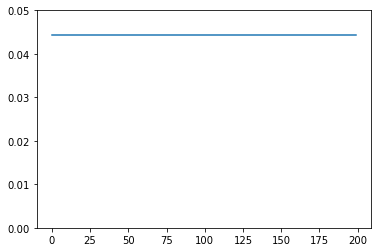

In [83]:
plt.plot(ϕ[:,0])
plt.ylim(0, 0.05)

In [ ]:
ϕ[:, 10]

In [67]:
import pickle

In [70]:
with open('solu_modified_40200_0900', 'rb') as handle:
    b = pickle.load(handle)
ϕ_suri = b['phi']

In [124]:
ϕ[10, :]

array([0.04436461, 0.04360322, 0.04341324, 0.04327853, 0.04316539,
       0.04306559, 0.04297538, 0.04289262, 0.04281591, 0.04274433,
       0.0426773 , 0.0426141 , 0.04255404, 0.04249666, 0.04244164,
       0.04238872, 0.04233771, 0.04228844, 0.04224078, 0.04219465])

(0.0, 0.05)

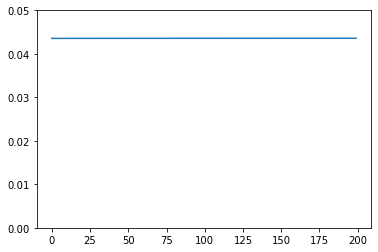

In [81]:
plt.plot(ϕ_suri[0, :])
plt.ylim(0, 0.05)

In [117]:
ϕ_suri_new = ϕ_suri.T.reshape(-1, order='F')

In [120]:
res = solver(ϕ_suri_new, r_grid, z_grid, ϵ, τ, δ, η, ξ_m, μ_2, σ_2, ρ)

In [122]:
np.abs(np.max((res - ϕ_suri_new)/ϵ))

6.714514713471176e-06